1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score, average_precision_score, confusion_matrix
from ELI5 import PermutationImportance

In [2]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

In [3]:
def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=-1,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf, f1_test

In [11]:
def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [8]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

Wall time: 25.1 s


Взаимная информация

In [9]:
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

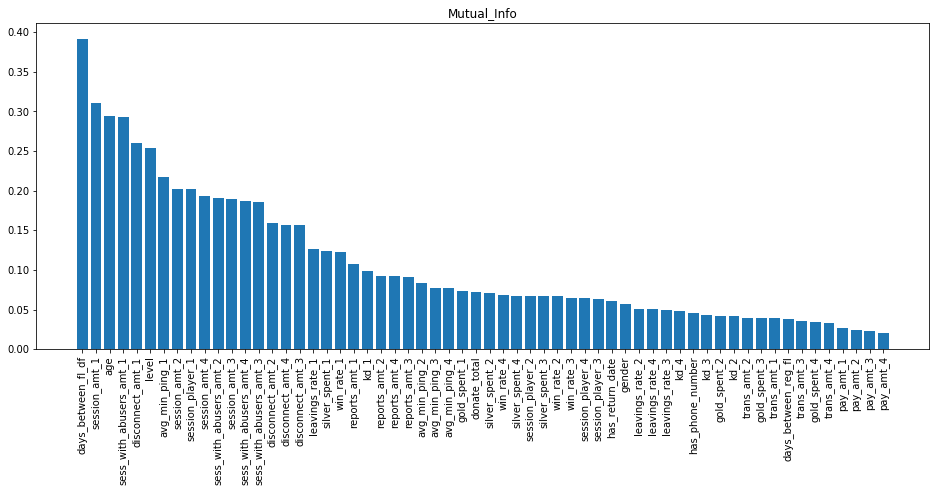

In [12]:
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [13]:
X_train_mi = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_mi = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

In [14]:
fitted_clf = xgb_fit_predict(X_train_mi, y_train_balanced, X_test_mi, y_test)

Precision: 0.29243318292259635
Recall: 0.4062198649951784
F1: 0.34006054490413723
Log Loss: 0.1342371066456897
ROC AUC: 0.8951090222504733


RFE 

In [17]:
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50


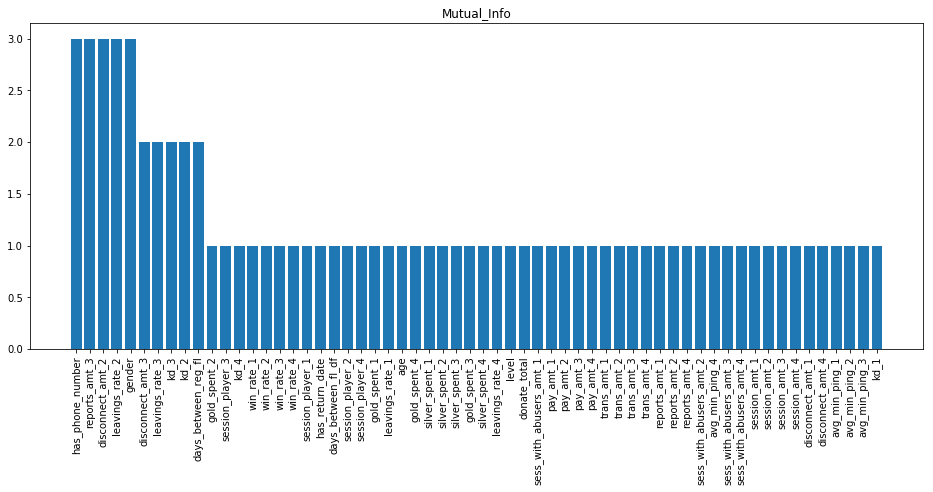

In [18]:
feature_importance = plot_importance(selector.ranking_, X.columns, 'Mutual_Info')

In [19]:
X_train_rfe = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_rfe = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.2870936594785967
Recall: 0.43008678881388623
F1: 0.3443350704497201
Log Loss: 0.13594830805932462
ROC AUC: 0.8967121299934184


PI

In [20]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.2941948179731059
Recall: 0.4324975891996143
F1: 0.3501854382197931
Log Loss: 0.13335087791640302
ROC AUC: 0.8987857163794006


In [22]:
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

TypeError: not all arguments converted during string formatting

In [ ]:
res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

In [ ]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

In [ ]:
feature_importance = plot_importance(res['score'], X.columns, 'Mutual_Info')

In [ ]:
X_train_pi = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_pi = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_pi, y_train_balanced, X_test_pi, y_test)

2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.